In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain_experimental langchain-google-vertexai pydantic==2.9.1

In [2]:
from typing import Annotated

from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

repl = PythonREPL()

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """
    Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user.
    """
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return result_str

# Create Agent Supervisor

In [3]:
from langgraph.graph import MessagesState

# The agent state is the input to each node in the graph
class AgentState(MessagesState):
    # The 'next' field indicates where to route to next
    next: str

In [4]:
from typing import Literal
from typing_extensions import TypedDict

from langgraph.graph import END
from langchain_google_vertexai import ChatVertexAI

members = ["researcher", "coder"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]

llm = ChatVertexAI(model_name="gemini-1.5-flash-001")

def supervisor_node(state: AgentState) -> AgentState:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    next_ = response["next"]
    if next_ == "FINISH":
        next_ = END

    return {"next": next_}

# Construct Graph

In [5]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent


research_agent = create_react_agent(
    llm, tools=[], state_modifier="You are a researcher. DO NOT do any math."
)


def research_node(state: AgentState) -> AgentState:
    result = research_agent.invoke(state)
    return {
        "messages": [
            HumanMessage(content=result["messages"][-1].content, name="researcher")
        ]
    }


# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
code_agent = create_react_agent(llm, tools=[python_repl_tool])


def code_node(state: AgentState) -> AgentState:
    result = code_agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name="coder")]
    }


builder = StateGraph(AgentState)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", research_node)
builder.add_node("coder", code_node)

In [6]:
for member in members:
    builder.add_edge(member, "supervisor")

builder.add_conditional_edges("supervisor", lambda state: state["next"])
builder.add_edge(START, "supervisor")

graph = builder.compile()

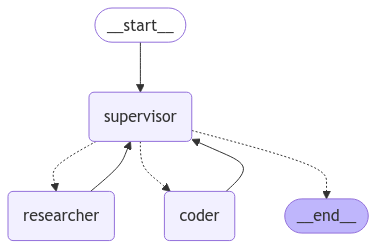

In [7]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
for s in graph.stream(
    {"messages": [("user", "What's the square root of 42?")]}, subgraphs=True
):
    print(s)
    print("----")

ValueError: no signature found for builtin type <class 'dict'>